In [188]:
import matplotlib.pyplot as plt
plt.rcParams['image.interpolation'] = 'none'
import numpy as np
import cv2
import math
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter1d
import itertools
from sklearn.cluster import DBSCAN

In [189]:
def display_images(imgs, titles, width=5):
    n = len(imgs)
    rows = math.ceil(n / 3)
    cols = n // rows
    h, w = imgs[0].shape[:2]
    fig, axs = plt.subplots(rows, cols, figsize=(width * cols, width * h / w * rows))
    axs = axs.flatten()
    for i in range(rows * cols):
        if i < n:
            img = imgs[i]
            axs[i].imshow(img, cmap='gray' if img.ndim == 2 else None)
            axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()


def to_float(img):
    img = img.astype(np.float64)
    return (img - np.min(img)) / (np.max(img) - np.min(img))

def to_uint8(img):
    norm = (img - np.min(img)) / (np.max(img) - np.min(img))
    return np.round(norm * 255).astype(np.uint8)

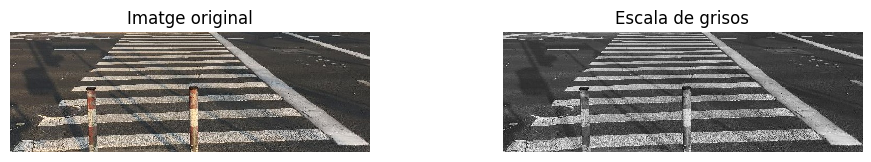

In [190]:
# path = "../data/examples_cropped/heon_IMG_0534.JPG" # Ombres
# path = "../data/examples_cropped/sam_IMG_1379.jpg" # Vía
# path = "../data/examples_cropped/heon_IMG_0520.JPG" # Il·luminació horrible
# path = "../data/examples_cropped/sam_IMG_6482.jpg" # Neu
path = "../data/examples_cropped/heon_IMG_0588.JPG" # Normal
# path = "../data/examples_cropped/sam_IMG_1397.jpg" # Esborrat
# path = "../data/examples_cropped/sam_IMG_1344.jpg" # Farola


img = plt.imread(path)
height, width, channels = img.shape
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

display_images([img, gray], ['Imatge original', 'Escala de grisos'])

In [191]:
# exp = np.pow(np.e, to_float(gray))
# exp = to_uint8(exp)

# plt.imshow(exp, cmap='gray')
# plt.title('Filtre exponencial (Realça blancs)')
# plt.axis('off')
# plt.show()

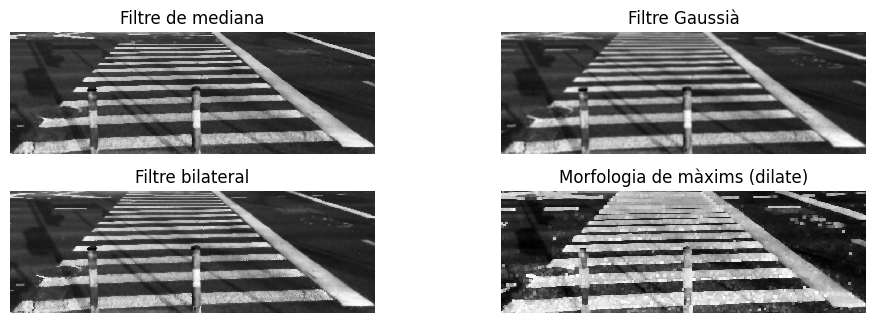

In [192]:
src = gray

med = cv2.medianBlur(src, 5)

sigma = 1.5
ksize = round(6 * sigma + 1)
ksize = ksize + 1 - (ksize % 2)
blur = cv2.GaussianBlur(src, (ksize, ksize), sigma)

bilat = cv2.bilateralFilter(src, d=6, sigmaColor=75, sigmaSpace=75)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
max = cv2.morphologyEx(src, cv2.MORPH_DILATE, kernel)

display_images([med, blur, bilat, max], ['Filtre de mediana', 'Filtre Gaussià', 'Filtre bilateral', 'Morfologia de màxims (dilate)'])

### 1st approach

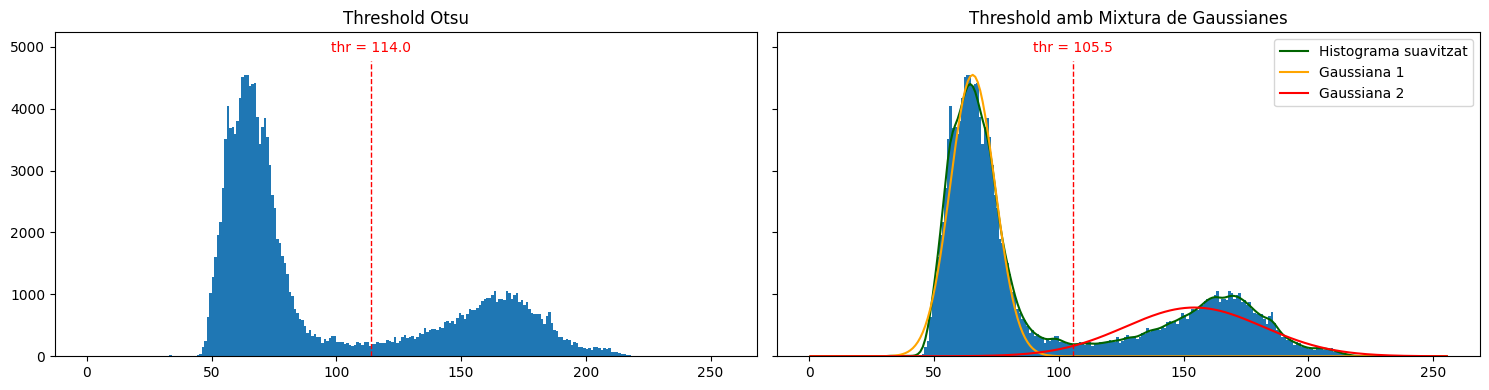

In [193]:
src = med

# Otsu
hist, bins = np.histogram(src, bins=256, range=(0, 256))
thr1, bw = cv2.threshold(src, 0, 256, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Mixtura de Gaussianes
sample = cv2.resize(src, (14, 14), interpolation=cv2.INTER_CUBIC).reshape(-1, 1)
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(sample)
means = gmm.means_.flatten()
covs = gmm.covariances_.flatten()
weights = gmm.weights_.flatten()
m1, m2 = np.sort(means)

hist_smooth = gaussian_filter1d(hist, sigma=2)
bin_centers = (bins[:-1] + bins[1:]) / 2

mask = (bin_centers > m1) & (bin_centers < m2)
thr2 = bin_centers[mask][np.argmin(hist_smooth[mask])]

pdf1 = weights[0] * np.exp(-0.5 * ((bin_centers - means[0])**2) / covs[0]) / np.sqrt(2 * np.pi * covs[0])
pdf2 = weights[1] * np.exp(-0.5 * ((bin_centers - means[1])**2) / covs[1]) / np.sqrt(2 * np.pi * covs[1])
pdf_scale = np.max(hist) / np.max(pdf1 + pdf2)

# Gràfica
fig, axs = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

axs[0].bar((bins[1:] + bins[:-1]) / 2, hist, width=1)
axs[0].axvline(thr1, color='red', linestyle='--', linewidth=1, ymax=0.91)
axs[0].text(float(thr1), np.max(hist) * 1.08, f'thr = {thr1:.1f}', color='red', ha='center')
axs[0].set_ylim(0, np.max(hist) * 1.15)
axs[0].set_title('Threshold Otsu')

axs[1].bar(bin_centers, hist, width=1)
axs[1].plot(bin_centers, hist_smooth, color='darkgreen', label='Histograma suavitzat')
axs[1].plot(bin_centers, pdf1 * pdf_scale, color='orange', label='Gaussiana 1')
axs[1].plot(bin_centers, pdf2 * pdf_scale, color='red', label='Gaussiana 2')
axs[1].axvline(thr2, color='red', linestyle='--', linewidth=1, ymax=0.91)
axs[1].text(float(thr2), np.max(hist) * 1.08, f'thr = {thr2:.1f}', color='red', ha='center')
axs[1].set_ylim(0, np.max(hist) * 1.15)
axs[1].set_title('Threshold amb Mixtura de Gaussianes')
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()


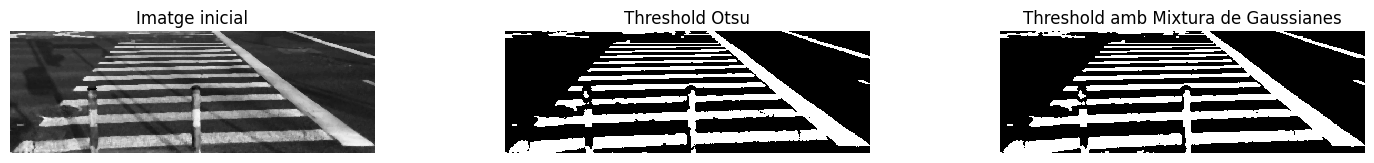

In [194]:
src = med

bw1 = 255*(src > thr1).astype(np.uint8)
bw2 = 255*(src > thr2).astype(np.uint8)


display_images([src, bw1, bw2], ['Imatge inicial', 'Threshold Otsu', 'Threshold amb Mixtura de Gaussianes'])

### Top-hat problem


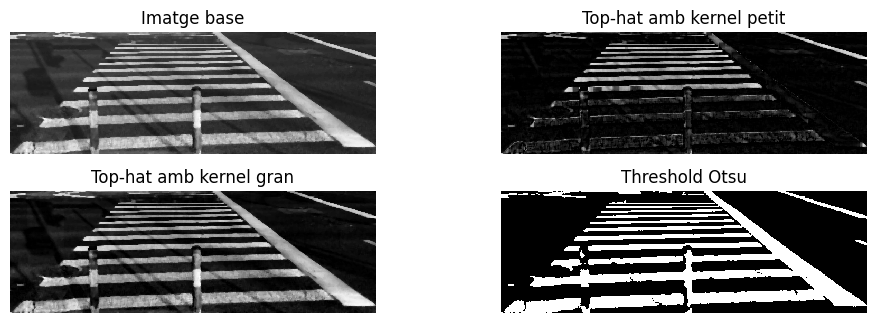

In [195]:
src = med

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
top_hat1 = cv2.morphologyEx(src, cv2.MORPH_TOPHAT, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (60, 60))
top_hat2 = cv2.morphologyEx(src, cv2.MORPH_TOPHAT, kernel)

_, bw4 = cv2.threshold(top_hat2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

display_images([src, top_hat1, top_hat2, bw4], ['Imatge base', 'Top-hat amb kernel petit', 'Top-hat amb kernel gran', 'Threshold Otsu'])

### 2nd approach

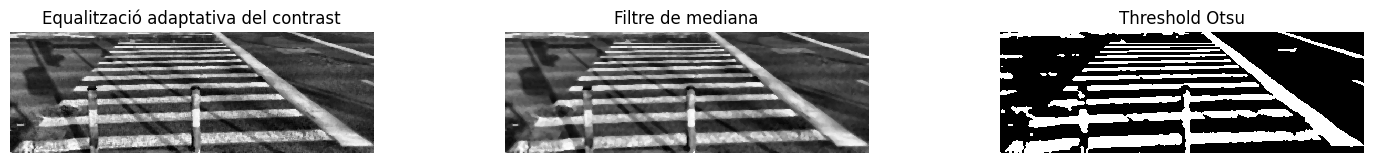

In [196]:
src = med

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
eq = clahe.apply(med)

eq_med = cv2.medianBlur(eq, ksize=5)

_, bw3 = cv2.threshold(eq_med, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

display_images([eq, eq_med, bw3], ['Equalització adaptativa del contrast', 'Filtre de mediana', 'Threshold Otsu'])

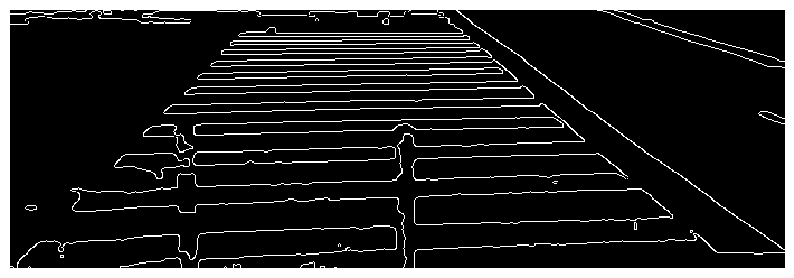

In [197]:
src = bw2

edges = cv2.Canny(src, 50, 150, apertureSize=3)

plt.figure(figsize=(10, 10))
plt.imshow(edges, cmap="gray")
plt.axis('off')
plt.show()

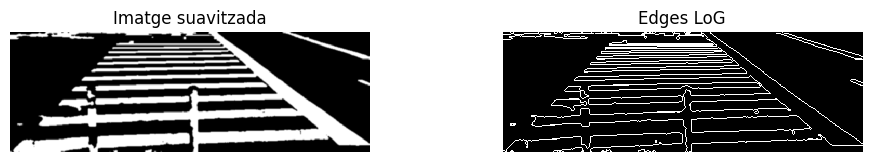

In [198]:
src = bw2

src_blur = cv2.GaussianBlur(src, (5,5), 0)
lap = cv2.Laplacian(src_blur, ddepth=cv2.CV_64F)

# Zero-crossings
z1 = np.roll(lap, 1, axis=0) * np.roll(lap, -1, axis=0)
z2 = np.roll(lap, 1, axis=1) * np.roll(lap, -1, axis=1)
edges = np.logical_or(z1 < 0, z2 < 0).astype(np.uint8) * 255


display_images([src_blur, edges], ['Imatge suavitzada', 'Edges LoG'])

In [199]:
# src = edges

# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
# morph = cv2.morphologyEx(src, cv2.MORPH_ERODE, kernel)
# morph = cv2.morphologyEx(morph, cv2.MORPH_DILATE, kernel)

# display_images([edges, morph], ['Edges LoG', 'Thin edges (Open)'])


In [200]:
# src = bw4

# contours, hierarchy = cv2.findContours(src, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# cont = np.zeros_like(src)
# cv2.drawContours(cont, contours, -1, 255, 1)

# plt.imshow(cont, cmap="grey")
# plt.title('FindContours()')
# plt.axis('off')
# plt.show()

### Hough

In [201]:
# src = edges

# lines = cv2.HoughLines(src, rho=1, theta=np.pi/180, threshold=180)
# img_lines = img.copy()

# if lines is not None:
#     for line in lines:
#         rho, theta = line[0]
#         a, b = np.cos(theta), np.sin(theta)
#         x0, y0 = a*rho, b*rho
#         x1 = int(x0 + 1000*(-b))
#         y1 = int(y0 + 1000*( a))
#         x2 = int(x0 - 1000*(-b))
#         y2 = int(y0 - 1000*( a))
#         cv2.line(img_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

# plt.imshow(img_lines)
# plt.tight_layout()
# plt.axis('off')
# plt.show()


In [202]:
# raw = cv2.HoughLinesP(src, rho=1, theta=np.pi/180, threshold=10, minLineLength=1, maxLineGap=400)
# img_lines = img.copy()

# if raw is not None:
#     for x1, y1, x2, y2 in raw[:, 0]:
#         cv2.line(img_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

# plt.imshow(img_lines)
# plt.axis('off')
# plt.show()

# if raw is not None:
#     lines = raw[:, 0]
#     x1, y1, x2, y2 = lines[:, 0], lines[:, 1], lines[:, 2], lines[:, 3]
#     dx = x2 - x1
#     dy = y2 - y1
#     lengths = np.hypot(dx, dy)
#     nx = -dy / lengths
#     ny = dx / lengths
#     thetas = np.arctan2(ny, nx)
#     thetas[thetas < 0] += np.pi
#     rhos = x1 * nx + y1 * ny
#     lines = np.vstack((rhos, thetas)).T
# else:
#     lines = np.empty((0, 2))


In [203]:
# lines = lines[:, 0]
# lines = lines[lines[:, 0].argsort()]
# # lines

In [204]:
# def filter_duplicate_lines(lines, rho_thr, theta_thr):
#     filtered = []
#     for r, t in lines:
#         if not any(abs(r - r2) < rho_thr and abs(t - t2) < theta_thr for r2, t2 in filtered):
#             filtered.append((r, t))
#     return np.array(filtered)

# filtered = filter_duplicate_lines(lines, 20, np.deg2rad(2))

# res = img.copy()
# for r, t in filtered:
#     a = np.cos(t)
#     b = np.sin(t)
#     x0 = a * r
#     y0 = b * r
#     pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
#     pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
#     cv2.line(res, pt1, pt2, (255, 0, 0), 2)

# plt.imshow(res)
# plt.axis('off')
# plt.show()


In [205]:
# img_lines = img.copy()
# length = 1000  # longitud amb la qual allargar

# if lines is not None:
#     for x1, y1, x2, y2 in lines[:, 0]:
#         dx, dy = x2 - x1, y2 - y1
#         norm = np.hypot(dx, dy)
#         if norm == 0:
#             continue
#         dx, dy = dx / norm, dy / norm
#         xa = int(x1 - dx * length)
#         ya = int(y1 - dy * length)
#         xb = int(x2 + dx * length)
#         yb = int(y2 + dy * length)
#         cv2.line(img_lines, (xa, ya), (xb, yb), (255, 0, 0), 2)

# plt.imshow(img_lines)
# plt.axis('off')
# plt.show()


In [206]:
def get_intersection(l1, l2):
    x1, y1, x2, y2 = l1
    x3, y3, x4, y4 = l2
    A1, B1, C1 = y2 - y1, x1 - x2, x2*y1 - x1*y2
    A2, B2, C2 = y4 - y3, x3 - x4, x4*y3 - x3*y4
    det = A1 * B2 - A2 * B1
    if det == 0:
        return None
    x = (B1 * C2 - B2 * C1) / det
    y = (C1 * A2 - C2 * A1) / det
    return (x, y)

def point_line_distance(x0, y0, x1, y1, x2, y2):
    num = abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1)
    den = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return num / den

In [207]:
def draw_lines(img, lines, title=None):
    output = img.copy()
    for x1, y1, x2, y2 in lines:
        cv2.line(output, (x1, y1), (x2, y2), (255, 0, 0), 1)
    plt.imshow(output)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()

In [208]:
# def get_filtered_lines(edges, min_cluster_size=5, min_separation=1, distance_thresh=30):
#     few_lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=240, minLineLength=10, maxLineGap=200)
#     lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=10, maxLineGap=200)
#     if few_lines is None or lines is None:
#         return [], []
#     few_lines = few_lines[:, 0, :]
#     lines = lines[:, 0, :]

#     draw_lines(img, few_lines, "Hough molt restrictiu")
#     draw_lines(img, lines, "Hough molt tolerant")

#     intersections = []
#     for l1, l2 in itertools.combinations(few_lines, 2):
#         pt = get_intersection(l1, l2)
#         if pt is not None and all(np.isfinite(pt)):
#             intersections.append(pt)
#     if not intersections:
#         return [], []
#     intersections = np.array(intersections)

#     clustering = DBSCAN(eps=40, min_samples=min_cluster_size).fit(intersections)
#     labels = clustering.labels_
#     unique_labels = np.unique(labels[labels != -1])
#     cluster_sizes = np.array([np.sum(labels == k) for k in unique_labels])
#     centroids = np.stack([intersections[labels == k].mean(axis=0) for k in unique_labels])
#     centroids = centroids[np.argsort(cluster_sizes)[::-1]]
#     points = []
#     for centroid in centroids: 
#         if all(centroid[0]-p[0]>min_separation and centroid[1]-p[1]>min_separation for p in points):
#             points.append(centroid)
#     points = np.array(points)

#     filtered_lines = []
#     for line in lines:
#         for vp in points:
#             d = point_line_distance(vp[0], vp[1], *line)
#             if d < distance_thresh:
#                 filtered_lines.append(line)
#                 break
#     filtered_lines = np.array(filtered_lines)

#     return filtered_lines, points

In [209]:
# def filter_hough_rho(lines, rho_eps=20, theta_eps=np.pi/36, min_lines=1):
#     if len(lines) == 0:
#         return np.array([])
    
#     lines = np.array(lines)

#     def to_hough_space(x1, y1, x2, y2):
#         dx, dy = x2 - x1, y2 - y1
#         theta = np.arctan2(dy, dx)
#         if theta < 0:
#             theta += np.pi
#         rho = x1 * np.cos(theta) + y1 * np.sin(theta)
#         return rho, theta

#     hough_lines = np.array([to_hough_space(*line) for line in lines])
#     clustering = DBSCAN(eps=1e-3, min_samples=min_lines, metric=lambda a, b: np.hypot((a[0]-b[0])/rho_eps, (a[1]-b[1])/theta_eps)).fit(hough_lines)
#     labels = clustering.labels_

#     unique_labels = np.unique(labels[labels != -1])
#     representative_lines = []
#     for label in unique_labels:
#         idx = np.where(labels == label)[0]
#         cluster = lines[idx]
#         lengths = np.linalg.norm(cluster[:, :2] - cluster[:, 2:], axis=1)
#         representative_lines.append(cluster[np.argmax(lengths)])

#     return np.array(representative_lines)

In [210]:
# filtered_lines, points = get_filtered_lines(edges)
# # representative_lines = filter_hough_clusters(filtered_lines)
# draw_lines(img, filtered_lines)
# points

# Sense p

In [211]:
def get_intersection(l1, l2):
    rho1, theta1 = l1
    rho2, theta2 = l2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    if np.abs(np.linalg.det(A)) < 1e-6:
        return None
    intersection = np.linalg.solve(A, b)
    return intersection.flatten()

def point_line_distance(x0, y0, rho, theta):
    return abs(x0 * np.cos(theta) + y0 * np.sin(theta) - rho)

In [212]:
def get_filtered_lines(edges, min_cluster_size=5, min_separation=1, distance_thresh=30, eps=40):
    few_raw = cv2.HoughLines(edges, 1, np.pi/180, threshold=240)
    raw = cv2.HoughLines(edges, 1, np.pi/180, threshold=150)
    if few_raw is None or raw is None:
        return [], []

    few_lines = few_raw[:, 0, :]
    lines = raw[:, 0, :]

    draw_lines(img, few_lines, "Hough restrictiu", polar=True)
    draw_lines(img, lines, "Hough molt tolerant", polar=True)

    intersections = []
    for l1, l2 in itertools.combinations(few_lines, 2):
        pt = get_intersection(l1, l2)
        if pt is not None and np.all(np.isfinite(pt)):
            intersections.append(pt)
    if not intersections:
        return few_lines, []
    intersections = np.array(intersections)

    # max_eps = 300
    # step = 20

    clustering = DBSCAN(eps=eps, min_samples=min_cluster_size).fit(intersections)
    labels = clustering.labels_

    # while np.sum(labels != -1)==0 and eps <= max_eps:
    #     eps += step
    #     clustering = DBSCAN(eps=eps, min_samples=min_cluster_size).fit(intersections)
    #     labels = clustering.labels_

    # if eps > max_eps:
    if np.sum(labels != -1)==0:
        return few_lines, []

    unique_labels = np.unique(labels[labels != -1])
    cluster_sizes = np.array([np.sum(labels == k) for k in unique_labels])
    centroids = np.stack([intersections[labels == k].mean(axis=0) for k in unique_labels])
    centroids = centroids[np.argsort(cluster_sizes)[::-1]]

    points = []
    for centroid in centroids:
        # if all(np.linalg.norm(centroid - p) > min_separation for p in points):
        if all(centroid[0]-p[0]>min_separation and centroid[1]-p[1]>min_separation for p in points):
            points.append(centroid)
    points = np.array(points)
    # points = np.array([centroids[0,:]])

    filtered_lines = []
    for rho, theta in lines:
        for x, y in points:
            if point_line_distance(x, y, rho, theta) < distance_thresh:
                filtered_lines.append([rho, theta])
                break
    filtered_lines = np.array(filtered_lines)

    return filtered_lines, points

In [213]:
def draw_lines(img, lines, title=None, polar=True, color=(255, 0, 0), thickness=1):
    img_copy = img.copy()
    if polar:
        for rho, theta in lines:
            a, b = np.cos(theta), np.sin(theta)
            x0, y0 = a * rho, b * rho
            x1, y1 = int(x0 + 1000 * -b), int(y0 + 1000 * a)
            x2, y2 = int(x0 - 1000 * -b), int(y0 - 1000 * a)
            cv2.line(img_copy, (x1, y1), (x2, y2), color, thickness)
    else:
        for x1, y1, x2, y2 in lines:
            cv2.line(img_copy, (x1, y1), (x2, y2), color, thickness)

    cv2.imwrite("./"+title.replace(" ","_")+".png", cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))

    plt.figure(figsize=(10, 10))
    plt.imshow(img_copy)
    if title is not None: plt.title(title)
    plt.axis('off')
    plt.show()

In [214]:
def filter_hough_rho(lines, rho_eps=10):
    if len(lines) == 0:
        return np.array([])

    lines = np.array(lines)
    selected = []

    for rho, theta in lines:
        keep = True
        for r_sel, t_sel in selected:
            if abs(rho - r_sel) <= rho_eps:
                keep = False
                break
        if keep:
            selected.append([rho, theta])

    return np.array(selected)

In [215]:
# Provant coses, no incloure
import numpy as np

def filter_lines_by_intersection(lines, shape):
    if len(lines) == 0:
        return np.array([])

    lines = np.array(lines)
    h, w = shape[:2]
    theta_mean = np.mean(lines[:, 1])
    keep = np.ones(len(lines), dtype=bool)

    def get_line_points(rho, theta):
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = np.array([x0 + 1000 * -b, y0 + 1000 * a])
        pt2 = np.array([x0 - 1000 * -b, y0 - 1000 * a])
        return pt1, pt2

    def intersection(p1, p2, q1, q2):
        A = np.array([[p2[0] - p1[0], q1[0] - q2[0]],
                      [p2[1] - p1[1], q1[1] - q2[1]]])
        b = np.array([q1[0] - p1[0], q1[1] - p1[1]])
        if np.linalg.matrix_rank(A) < 2:
            return None
        t = np.linalg.solve(A, b)
        return p1 + t[0] * (p2 - p1)

    for i in range(len(lines)):
        if not keep[i]:
            continue
        rho1, theta1 = lines[i]
        p1, p2 = get_line_points(rho1, theta1)
        for j in range(i + 1, len(lines)):
            if not keep[j]:
                continue
            rho2, theta2 = lines[j]
            q1, q2 = get_line_points(rho2, theta2)
            inter = intersection(p1, p2, q1, q2)
            if inter is not None:
                x, y = inter
                if 0 <= x < w and 0 <= y < h:
                    dist_i = abs(theta1 - theta_mean)
                    dist_j = abs(theta2 - theta_mean)
                    if dist_i > dist_j:
                        keep[i] = False
                        break
                    else:
                        keep[j] = False

    return lines[keep]



In [216]:
# import numpy as np

# def filter_lines_by_intersection(lines, shape, points):
#     if len(lines) == 0:
#         return np.array([])

#     lines = np.array(lines)
#     h, w = shape[:2]
#     keep = np.ones(len(lines), dtype=bool)

#     def min_distance_to_points(rho, theta, points):
#         return min(point_line_distance(x, y, rho, theta) for (x, y) in points)

#     for i in range(len(lines)):
#         if not keep[i]:
#             continue
#         for j in range(i + 1, len(lines)):
#             if not keep[j]:
#                 continue
#             inter = get_intersection(lines[i], lines[j])
#             if inter is not None:
#                 x, y = inter
#                 if 0 <= x < w and 0 <= y < h:
#                     d1 = min_distance_to_points(lines[i][0], lines[i][1], points)
#                     d2 = min_distance_to_points(lines[j][0], lines[j][1], points)
#                     if d1 > d2:
#                         keep[i] = False
#                         break
#                     else:
#                         keep[j] = False

#     return lines[keep]


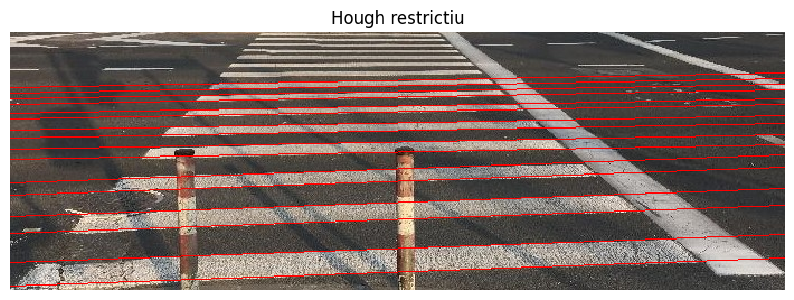

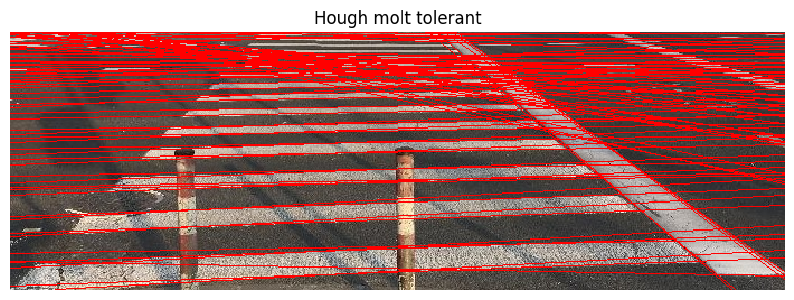

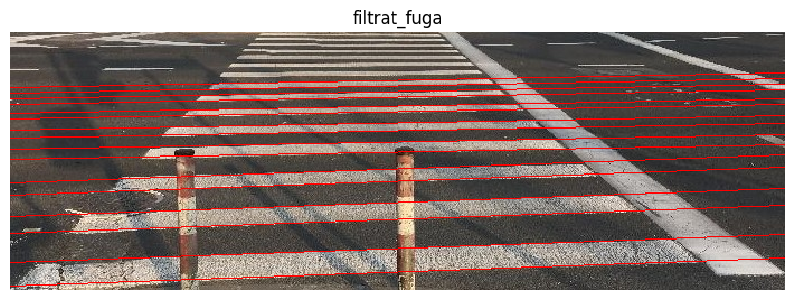

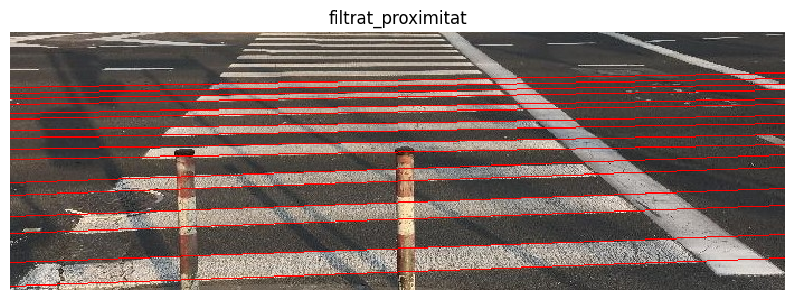

[]

In [217]:
filtered_lines, points = get_filtered_lines(edges)
# representative_lines = filter_hough_rho(filtered_lines, rho_eps=5)
representative_lines = filter_lines_by_intersection(filtered_lines, img.shape)
draw_lines(img, filtered_lines, "filtrat_fuga")
draw_lines(img, representative_lines, "filtrat_proximitat")
points

In [218]:
def segment_from_rho_theta(rho, theta, edge_img, epsilon=1.0):

    ys, xs = np.nonzero(edge_img) 
    pts = np.stack([xs, ys], axis=1).astype(np.float32)
    n = np.array([np.cos(theta), np.sin(theta)]) 
    v = np.array([-np.sin(theta),  np.cos(theta)])
    d = np.abs(pts @ n - rho) # per cada punt x,y --> xcosθ+ysinθ || d és la distància perpendicular de cada punt a la recta
    on_line = pts[d < epsilon]
    if len(on_line) < 2:
        return None
    t = on_line @ v
    p_min = on_line[np.argmin(t)]
    p_max = on_line[np.argmax(t)]
    return tuple(p_min.astype(int)), tuple(p_max.astype(int))


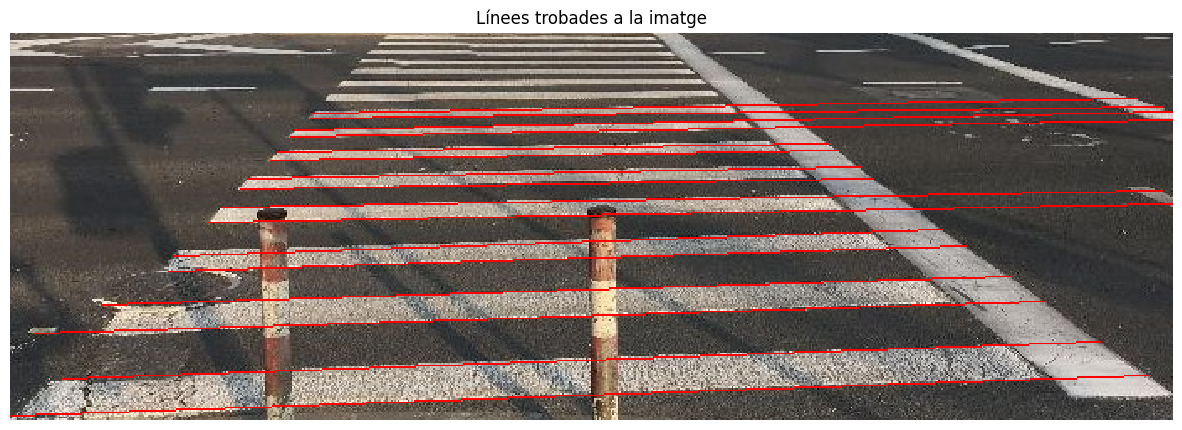

In [219]:
img_draw = img.copy()

for (rho, theta) in representative_lines:
    extremos = segment_from_rho_theta(rho, theta, edges, epsilon=1.5)
    if extremos:
        cv2.line(img_draw, *extremos, (255,0,0), 1) #FORMAT BGR

plt.figure(figsize=(15, 10))

# img_rgb = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)

plt.imshow(img_draw)
plt.axis("off")
plt.title("Línees trobades a la imatge")
plt.show()


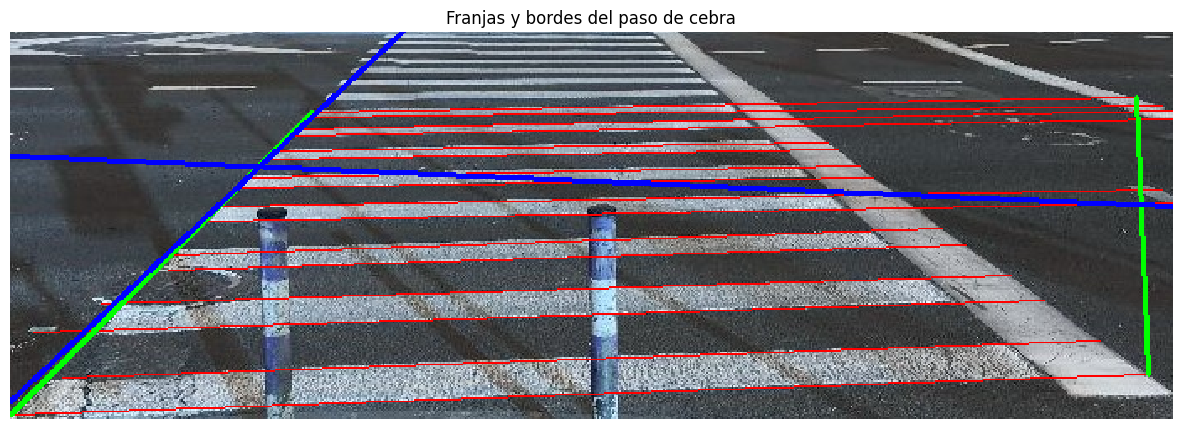

In [220]:
segments = []
img_draw = img.copy()

for (rho, theta) in representative_lines:
    extremos = segment_from_rho_theta(rho, theta, edges, epsilon=1.5)
    if extremos is not None:
        segments.append(extremos)
        cv2.line(img_draw, *extremos, (0, 0, 255), 1)

if len(segments) < 2:
    print("No hay suficientes franjas detectadas para dibujar los bordes laterales.")
else:
    segments.sort(key=lambda s: ((s[0][1] + s[1][1]) / 2), reverse=True)

    left_pts, right_pts = [], []
    for p_min, p_max in segments:
        if p_min[0] < p_max[0]:
            left_pts.append(p_min)
            right_pts.append(p_max)
        else:
            left_pts.append(p_max)
            right_pts.append(p_min)

    left_pts  = np.array(left_pts , dtype=np.float32)
    right_pts = np.array(right_pts, dtype=np.float32)

    # <------------------------ A --------------------->
    ptA1 = tuple(left_pts [0].astype(int))
    ptA2 = tuple(left_pts [-1].astype(int))
    ptB1 = tuple(right_pts[0].astype(int))
    ptB2 = tuple(right_pts[-1].astype(int))

    cv2.line(img_draw, ptA1, ptA2, (0, 255, 0), 2)
    cv2.line(img_draw, ptB1, ptB2, (0, 255, 0), 2)
    # <------------------------------------------------>

    # <------------------------ B --------------------->
    def line_from_points(pts, shape):
        vx, vy, x0, y0 = cv2.fitLine(pts, cv2.DIST_L2, 0, 0.01, 0.01)
        h, w = shape[:2]
        t0 = (-x0) / vx 
        t1 = (w - x0) / vx
        p1 = (int(x0 + t0*vx), int(y0 + t0*vy))
        p2 = (int(x0 + t1*vx), int(y0 + t1*vy))
        return p1, p2

    ptL1, ptL2 = line_from_points(left_pts , img.shape)
    ptR1, ptR2 = line_from_points(right_pts, img.shape)
    cv2.line(img_draw, ptL1, ptL2, (255, 0, 0), 2)
    cv2.line(img_draw, ptR1, ptR2, (255, 0, 0), 2)
    # <------------------------------------------------>

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Franjas y bordes del paso de cebra")
plt.show()

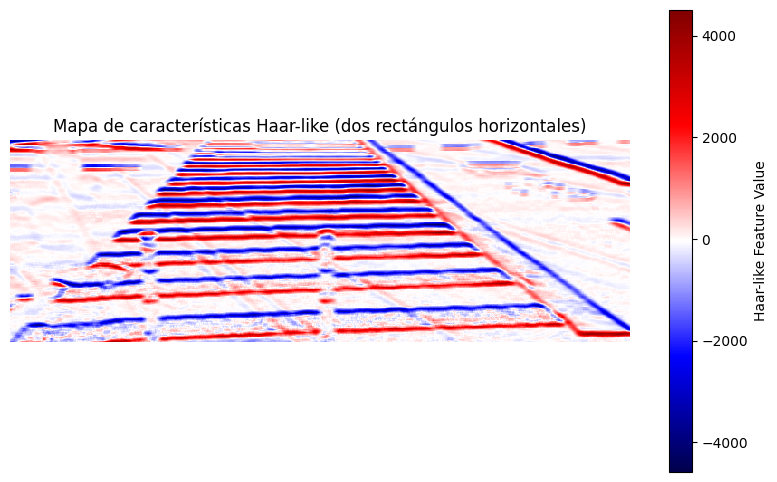

In [ ]:
# # Calcular imagen integral
# integral = cv2.integral(gray)

# # Tamaño de la ventana
# w, h = 8, 8
# half_h = h // 2

# # Crear un mapa para guardar los valores de la feature
# feature_map = np.zeros((gray.shape[0] - h, gray.shape[1] - w))

# # Función para suma de rectángulo
# def rect_sum(ii, x, y, w, h):
#     A = ii[y][x]
#     B = ii[y][x + w]
#     C = ii[y + h][x]
#     D = ii[y + h][x + w]
#     return D - B - C + A

# # Escanear con ventana deslizante
# for y in range(0, gray.shape[0] - h):
#     for x in range(0, gray.shape[1] - w):
#         top = rect_sum(integral, x, y, w, half_h)
#         bottom = rect_sum(integral, x, y + half_h, w, half_h)
#         feature_value = top - bottom
#         feature_map[y, x] = feature_value

# # Visualizar el mapa de valores
# plt.figure(figsize=(10, 6))
# plt.imshow(feature_map, cmap='seismic', interpolation='nearest')
# plt.colorbar(label='Haar-like Feature Value')
# plt.title('Mapa de características Haar-like (dos rectángulos horizontales)')
# plt.axis('off')
# plt.show()

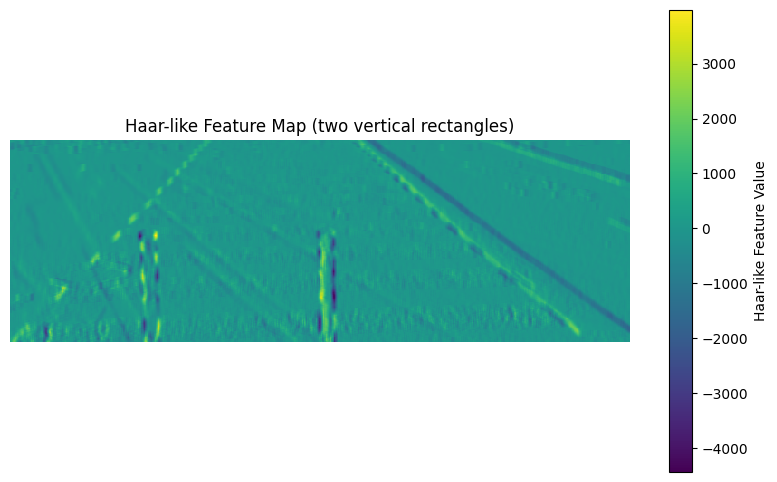

In [ ]:
# integral = cv2.integral(gray)

# w, h = 8, 8
# half_w = w // 2

# feature_map = np.zeros((gray.shape[0] - h, gray.shape[1] - w))

# def rect_sum(ii, x, y, w, h):
#     A = ii[y][x]
#     B = ii[y][x + w]
#     C = ii[y + h][x]
#     D = ii[y + h][x + w]
#     return D - B - C + A

# for y in range(0, gray.shape[0] - h):
#     for x in range(0, gray.shape[1] - w):
#         left = rect_sum(integral, x, y, half_w, h)
#         right = rect_sum(integral, x + half_w, y, half_w, h)
#         feature_value = -left + right
#         feature_map[y, x] = feature_value

# plt.figure(figsize=(10, 6))
# plt.imshow(feature_map, cmap='viridis', interpolation='nearest')
# plt.colorbar(label='Haar-like Feature Value')
# plt.title('Haar-like Feature Map (two vertical rectangles)')
# plt.axis('off')
# plt.show()
